## Configuration

In [56]:
%load_ext autoreload
%autoreload 2

import os, time, pytz, datetime
import optuna
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

from src.utils import evaluate_hitrate_at_3, make_submission
from src.feature import feature_engineering, feature_selection
from src.plot import plot_hitrate_at_k, plot_ndcg_curve
from src.data import split_dataset, split_dataset_leg
from src.params import get_hyper_params
from src.utils import TRAIN_VAL_SIZE

# Configurations
MODEL = "xgboost"
# Switch to True when training on full dataset
FULL = True
RANDOM_STATE = 42

try:
    TIME_TAG
except NameError:
    tz = pytz.timezone("Asia/Shanghai")
    TIME_TAG = datetime.datetime.now(tz).strftime("%Y%m%d%H%M%S")
print("Time Tag:", TIME_TAG)

DATA_DIR = "./data"
MODEL_DIR = "model"
SUBMIT_DIR = "submission"

# Create dir
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SUBMIT_DIR, exist_ok=True)

# Feature engineered df
feat_df_path = "feateng_full.parquet" if FULL else "feateng_not_full.parquet"
feat_df_path = os.path.join(DATA_DIR, feat_df_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time Tag: 20250814064508


## Data Processing

In [57]:
train = pl.read_parquet(os.path.join(DATA_DIR, "train.parquet")).drop(
    "__index_level_0__"
)
test = (
    pl.read_parquet(os.path.join(DATA_DIR, "test.parquet"))
    .drop("__index_level_0__")
    .with_columns(pl.lit(0, dtype=pl.Int64).alias("selected"))
)

val = train.slice(TRAIN_VAL_SIZE, train.height - TRAIN_VAL_SIZE)

df = pl.concat((train, test))


print("Successfully load parquet files!")

Successfully load parquet files!


## Feature Engineering

In [58]:
df = pl.read_parquet(feat_df_path)

## Feature Selection

In [59]:
X, y, groups, cat_features_final, num_features_final = feature_selection(df)

Using 147 features (74 categorical, 73 numerical)


## Train-Val-Test Split

In [60]:
dtrain, dval, dtest, dfull, _, _, _, X_va, y_va, groups_va, X_te, mask_va, mask_te = (
    split_dataset_leg(train, X, y, groups, cat_features_final, 2)
)
print("Data split finished!")

Data split finished!


In [61]:
del train, df, X
if not FULL:
    del dtest, dfull, X_te
else:
    del dtrain
import gc

gc.collect()

14944

## Tune hyperparams

In [62]:
import joblib
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

os.makedirs("optuna", exist_ok=True)
STUDY_FILENAME = f"optuna/{TIME_TAG}.pkl"


def load_or_create_study():
    try:
        study = joblib.load(STUDY_FILENAME)
        print(f"Loaded study from {STUDY_FILENAME}")
    except FileNotFoundError:
        study = optuna.create_study(
            direction="maximize",
            sampler=TPESampler(seed=RANDOM_STATE),
            pruner=SuccessiveHalvingPruner(),
        )
        print("Created new study")
    return study


def save_study(study):
    joblib.dump(study, STUDY_FILENAME)
    print(f"Saved study to {STUDY_FILENAME}")

In [63]:
def xgb_objective(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "max_depth": trial.suggest_int("max_depth", 10, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 10, 50),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.7),
        "gamma": trial.suggest_float("gamma", 1, 10),
        "lambda": trial.suggest_float("lambda", 1, 100, log=True),
        "alpha": trial.suggest_float("alpha", 1e-2, 100, log=True),
        "sampling_method": trial.suggest_categorical(
            "sampling_method", ["uniform", "gradient_based"]
        ),
        "objective": "rank:ndcg",
        "eval_metric": "ndcg@3",
        "seed": RANDOM_STATE,
        "n_jobs": 32,
        "device": "cuda",
        "tree_method": "gpu_hist",
    }

    num_boost_round = trial.suggest_int("num_boost_round", 500, 1500)

    evals_result = {}
    model = xgb.train(
        params,
        dtrain if not FULL else dfull,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "val")] if not FULL else [(dfull, "train")],
        early_stopping_rounds=100,
        verbose_eval=150,
        maximize=True,
        evals_result=evals_result,
    )

    ndcg = model.best_score
    trial.set_user_attr("best_ndcg@3", ndcg)

    return ndcg

In [64]:
# study = load_or_create_study()
# n_trials = 50
# for _ in range(n_trials):
#     study.optimize(xgb_objective, n_trials=1)
#     save_study(study)

# best_params = study.best_params
# best_params.update(
#     {
#         "objective": "rank:ndcg",
#         "eval_metric": "ndcg@3",
#         "seed": RANDOM_STATE,
#         "n_jobs": 32,
#         "device": "cuda",
#         "tree_method": "gpu_hist",
#     }
# )

In [65]:
best_params = get_hyper_params(MODEL)
print("Best params:", best_params)

Best params: {'learning_rate': 0.05789086653897983, 'max_depth': 12, 'min_child_weight': 17, 'subsample': 0.8905574405667547, 'colsample_bytree': 0.4968609706195911, 'gamma': 1.5390799498359304, 'lambda': 24.295747051442678, 'alpha': 0.30851448338609827, 'sampling_method': 'gradient_based', 'num_boost_round': 571, 'objective': 'rank:ndcg', 'eval_metric': 'ndcg@3', 'seed': 42, 'n_jobs': 32, 'device': 'cuda', 'tree_method': 'gpu_hist'}


## Model Training

In [66]:
print(f"Training final {MODEL} model...")
evals_result = {}
model = xgb.train(
    best_params,
    dtrain if not FULL else dfull,
    num_boost_round=600,
    evals=[(dtrain, "train"), (dval, "val")] if not FULL else [(dfull, "train")],
    verbose_eval=50,
    maximize=True,
    evals_result=evals_result,
)

Training final xgboost model...
[0]	train-ndcg@3:0.28059
[50]	train-ndcg@3:0.54904
[100]	train-ndcg@3:0.63256
[150]	train-ndcg@3:0.68785
[200]	train-ndcg@3:0.72183
[250]	train-ndcg@3:0.75067
[300]	train-ndcg@3:0.77567
[350]	train-ndcg@3:0.79462
[400]	train-ndcg@3:0.80915
[450]	train-ndcg@3:0.82362
[500]	train-ndcg@3:0.83442
[550]	train-ndcg@3:0.83979
[599]	train-ndcg@3:0.83979


In [67]:
# Save model
if FULL:
    model_path = os.path.join(MODEL_DIR, f"{MODEL}_{TIME_TAG}.json")
    model.save_model(model_path)
    print(f"Model saved to: {model_path}")

Model saved to: model/xgboost_20250814064508.json


In [68]:
# Evaluate
va_preds = evaluate_hitrate_at_3(
    val.filter(mask_va), dval, y_va, groups_va, model, True
)

shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ pred_score │
│ ---      ┆ ---                             ┆ ---      ┆ ---        │
│ i64      ┆ str                             ┆ i32      ┆ f32        │
╞══════════╪═════════════════════════════════╪══════════╪════════════╡
│ 16487391 ┆ 82965af7d1fc4a07a043c0d81bcd1f… ┆ 4        ┆ 0.163015   │
│ 16487392 ┆ 82965af7d1fc4a07a043c0d81bcd1f… ┆ 10       ┆ -1.031546  │
│ 16487393 ┆ 82965af7d1fc4a07a043c0d81bcd1f… ┆ 14       ┆ -4.53004   │
│ 16487394 ┆ 82965af7d1fc4a07a043c0d81bcd1f… ┆ 3        ┆ 0.18172    │
│ 16487395 ┆ 82965af7d1fc4a07a043c0d81bcd1f… ┆ 9        ┆ -0.937912  │
└──────────┴─────────────────────────────────┴──────────┴────────────┘
shape: (5, 3)
┌──────────┬─────────────────────────────────┬──────────┐
│ Id       ┆ ranker_id                       ┆ selected │
│ ---      ┆ ---                             ┆ ---      │
│ i64      ┆ str 

In [69]:
importance = model.get_score(importance_type="gain")
importance_df = pl.DataFrame(
    [{"feature": k, "importance": v} for k, v in importance.items()]
).sort("importance", descending=bool(1))

print(importance_df.to_pandas().to_string())

                                                    feature   importance
0                                      is_min_segments_leg1  2148.777344
1                                      is_min_segments_leg0   885.706116
2                                            is_direct_leg1   633.829712
3                                             free_exchange   195.993530
4                                           n_segments_leg0    94.676903
5                                           n_segments_leg1    88.924042
6                                               free_cancel    59.266014
7                                   legs1_all_cabin_level_1    50.429405
8                                   legs0_all_cabin_level_1    47.326431
9                                            is_direct_leg0    35.493729
10                               corporate_policy_compliant    33.389538
11                                   legs1_is_cross_country    31.965433
12                                   pricingInfo_is

## Error analysis and Visualization

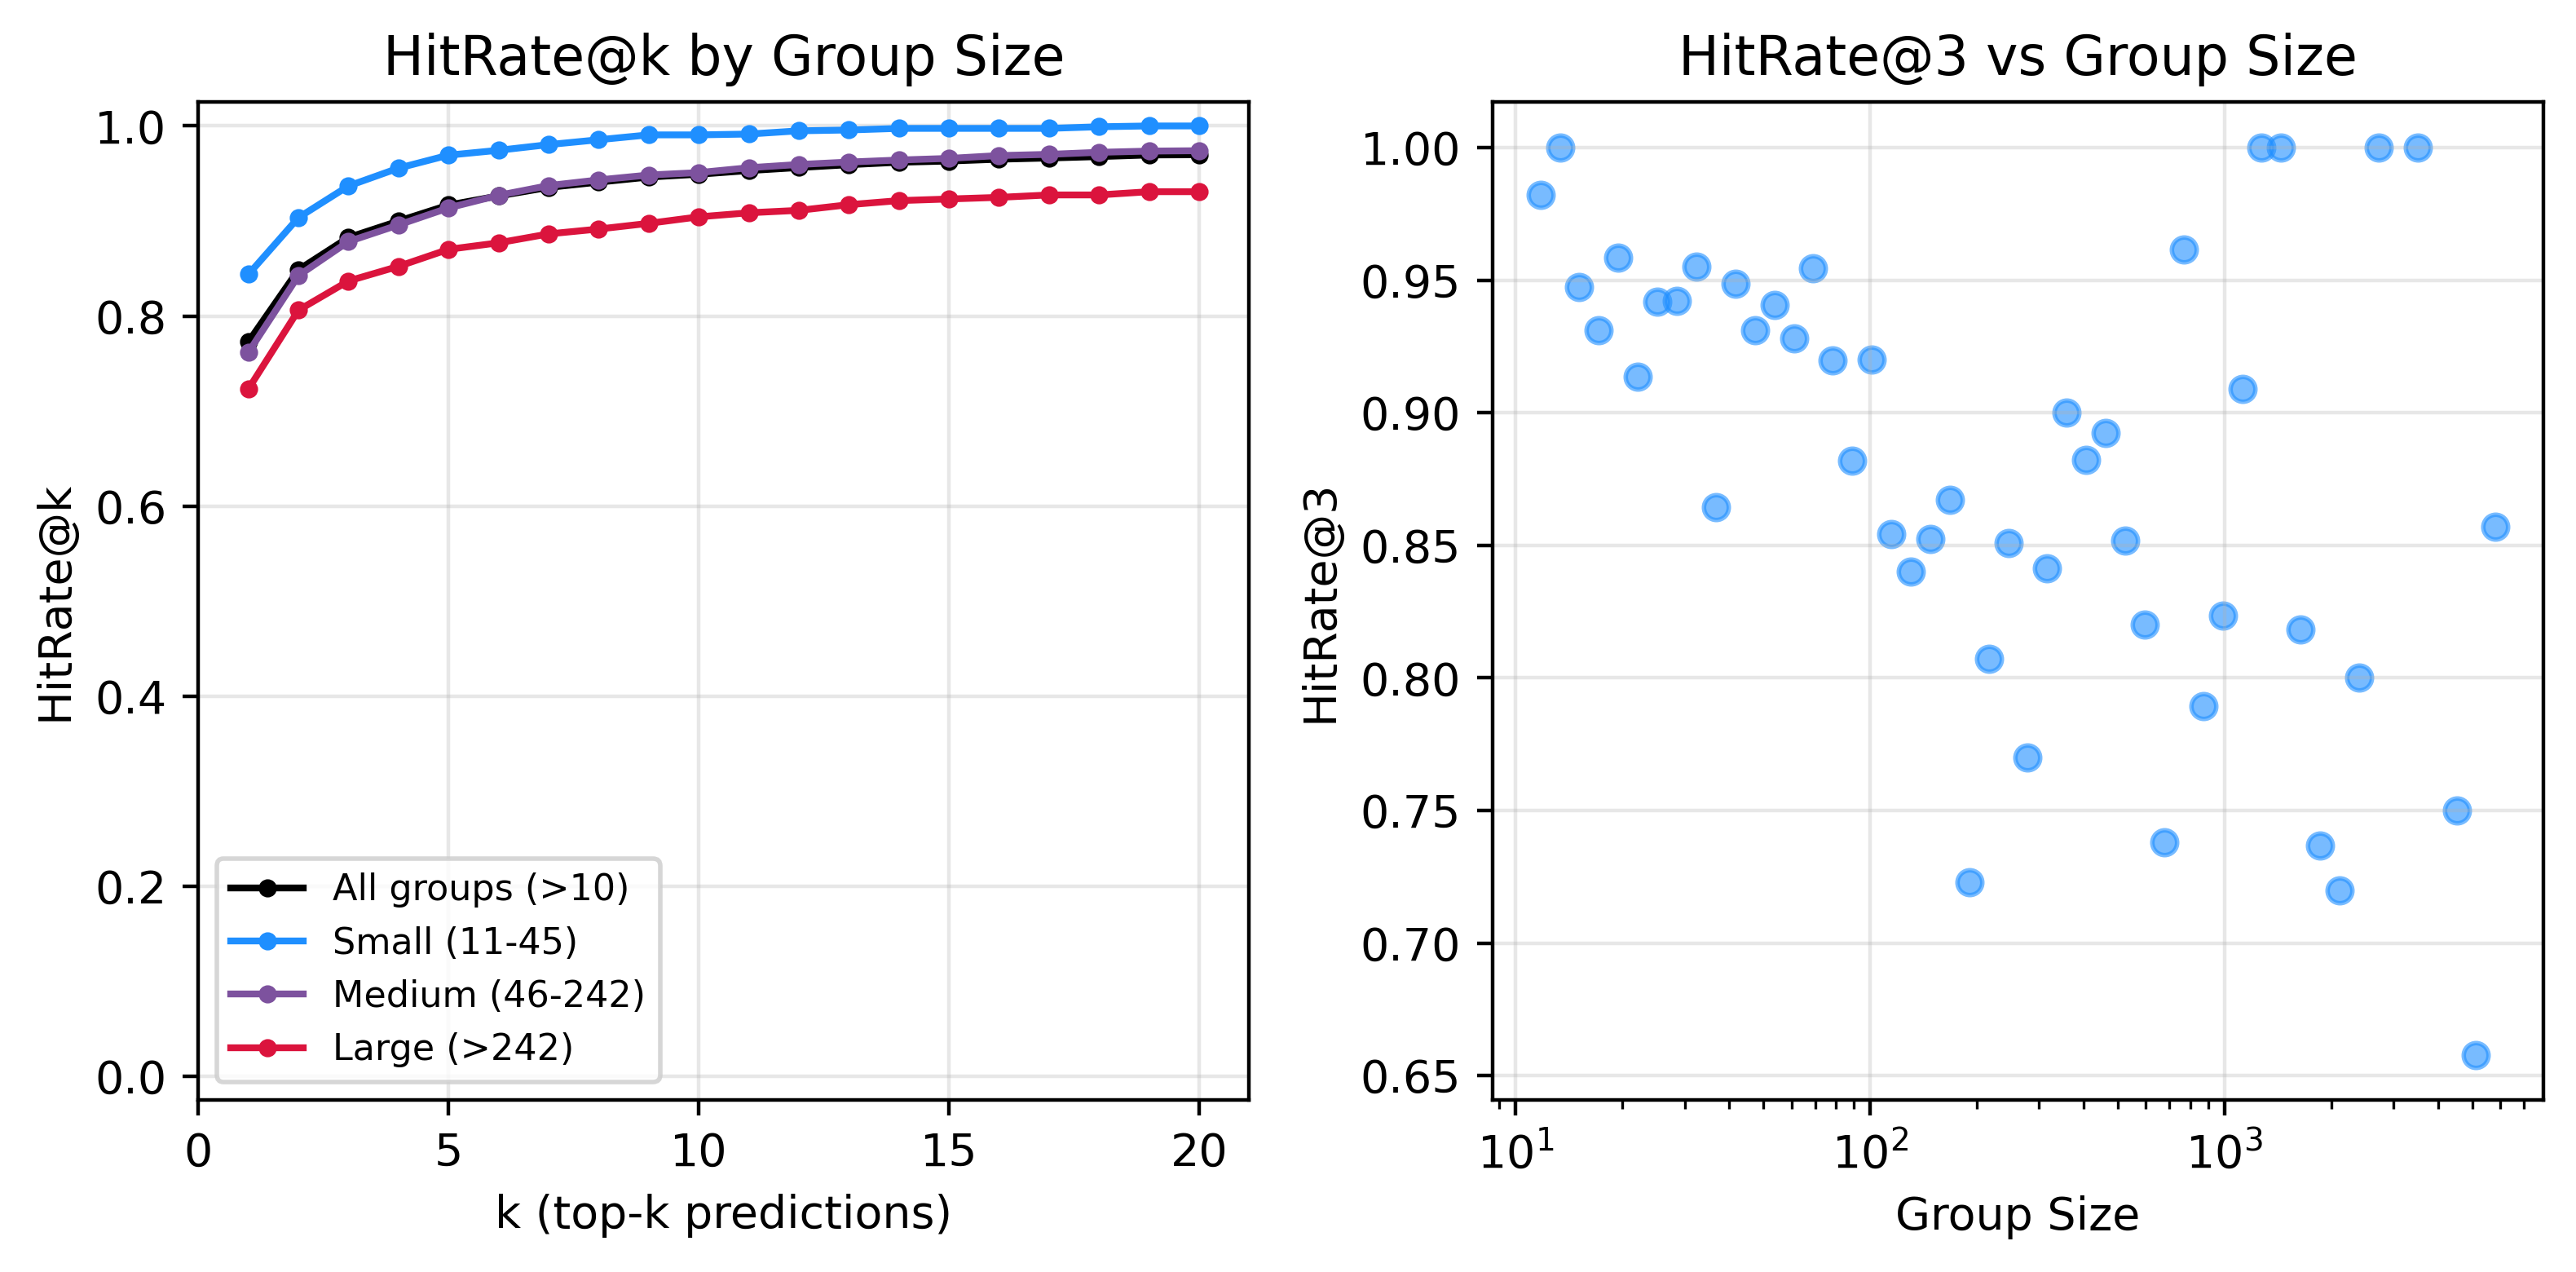

In [70]:
curves = plot_hitrate_at_k(groups_va, va_preds, y_va)

In [71]:
# Summary
print(f"HitRate@1: {curves['All groups (>10)'][0]:.5f}")
print(f"HitRate@3: {curves['All groups (>10)'][2]:.5f}")
print(f"HitRate@4: {curves['All groups (>10)'][3]:.5f}")
print(f"HitRate@5: {curves['All groups (>10)'][4]:.5f}")
print(f"HitRate@6: {curves['All groups (>10)'][5]:.5f}")
print(f"HitRate@10: {curves['All groups (>10)'][9]:.5f}")
print(f"HitRate@20: {curves['All groups (>10)'][19]:.5f}")

HitRate@1: 0.77294
HitRate@3: 0.88263
HitRate@4: 0.89991
HitRate@5: 0.91677
HitRate@6: 0.92638
HitRate@10: 0.94921
HitRate@20: 0.96970


## Submission

In [72]:
if FULL:
    submission_path = os.path.join(SUBMIT_DIR, f"submission_{TIME_TAG}.parquet")
    score_path = os.path.join(SUBMIT_DIR, "score", f"{TIME_TAG}.parquet")
    make_submission(test.filter(mask_te), dtest, model, submission_path, rerank=True)
    make_submission(test.filter(mask_te), dtest, model, score_path, True, True)

shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ pred_score │
│ ---      ┆ ---                             ┆ ---      ┆ ---        │
│ i64      ┆ str                             ┆ i32      ┆ f32        │
╞══════════╪═════════════════════════════════╪══════════╪════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 4        ┆ 0.309647   │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 14       ┆ 0.163037   │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 248      ┆ -3.759382  │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 80       ┆ -0.602218  │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 47       ┆ -0.215063  │
└──────────┴─────────────────────────────────┴──────────┴────────────┘
shape: (5, 3)
┌──────────┬─────────────────────────────────┬──────────┐
│ Id       ┆ ranker_id                       ┆ selected │
│ ---      ┆ ---                             ┆ ---      │
│ i64      ┆ str 

In [73]:
# !kaggle competitions submit -c aeroclub-recsys-2025 -f {submission_file} -m {TIME_TAG}